# CycleGAN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from pathlib import Path
from time import time
from IPython.display import clear_output
plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

BUFFER_SIZE = 1000
BATCH_SIZE = 8

LAMBDA = 10
EPOCHS = 150
CHECKPOINT_PATH = Path('./models/cycleGAN/')

## Загрузка и обработка данных

In [3]:
dataset, _ = tfds.load(name="cycle_gan/horse2zebra", with_info=True, as_supervised=True)

train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

In [4]:
def random_crop(image):
    image = tf.image.random_crop(
        image, size=[IMG_WIDTH, IMG_HEIGHT,  3]
    )
    return image

In [5]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [6]:
def random_jitter(image):
    image = tf.image.resize(image,
                            [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [7]:
def preprocess_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [8]:
def preprocess_test(image, label):
    image = normalize(image)
    return image

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_horses = train_horses.map(
    preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(
    preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

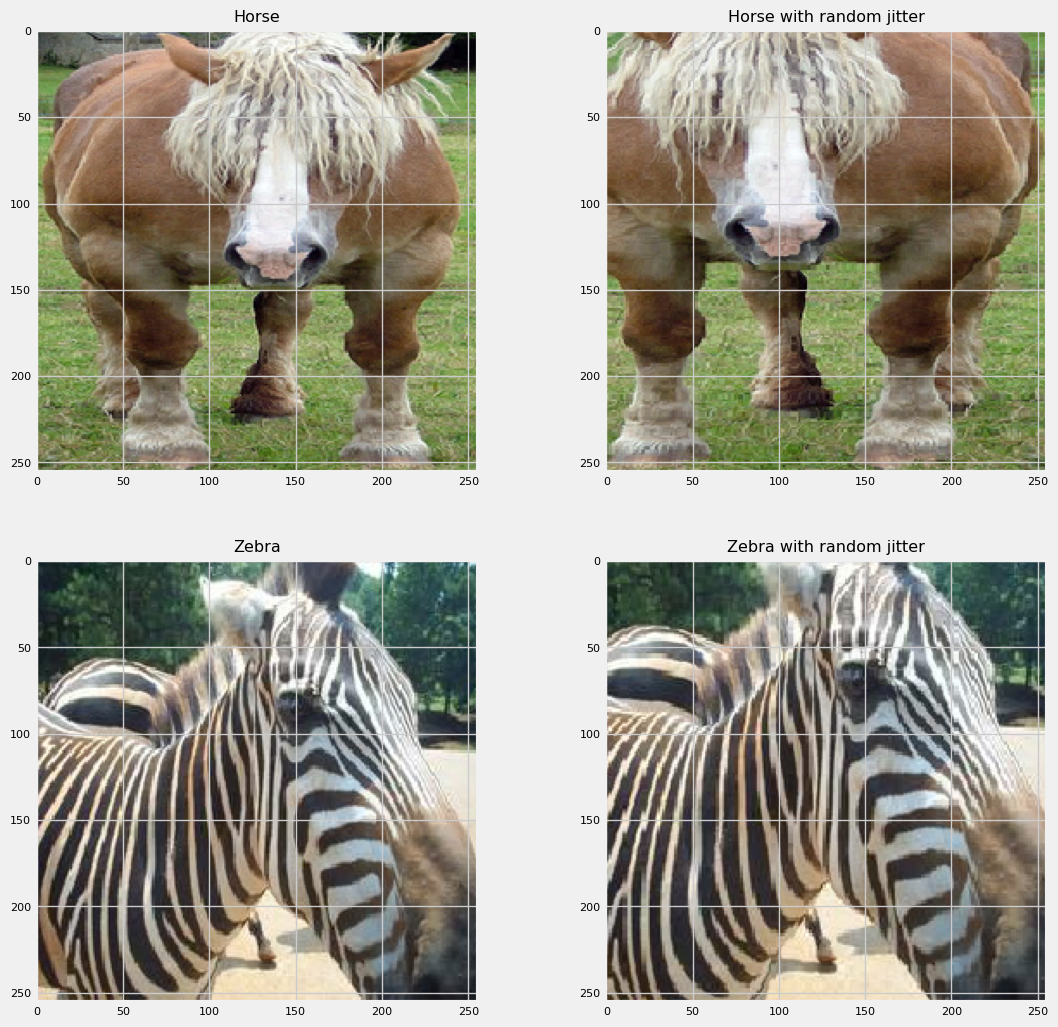

In [10]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(2, 2, 2)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

plt.subplot(2, 2, 3)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(2, 2, 4)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

plt.show()

## Разработка модели

In [11]:
class InstanceNormalization(keras.layers.Layer):

    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1.0, 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters,
                                  size,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  use_bias=False))

    if apply_batchnorm:
        model.add(InstanceNormalization())

    model.add(keras.layers.LeakyReLU())
    return model

In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    model = keras.Sequential()
    model.add(keras.layers.Conv2DTranspose(filters,
                                           size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           use_bias=False))

    if apply_dropout:
        model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.ReLU())
    return model

In [14]:
def Generator(output_channels=3):
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last_layer = keras.layers.Conv2DTranspose(output_channels,
                                              kernel_size=4,
                                              strides=2,
                                              padding='same',
                                              kernel_initializer=initializer,
                                              activation='tanh')

    inputs = keras.layers.Input(shape=[None, None, 3])
    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last_layer(x)
    return keras.Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator(target=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    inp = keras.layers.Input(shape=[None, None, 3], name='input_image')

    inputs = inp
    x = inputs
    if target:
        tar = keras.layers.Input(shape=[None, None, 3], name='target_image')
        inputs.append(tar)
        x = keras.layers.concatenate(inputs)

    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    x = keras.layers.ZeroPadding2D()(x)
    x = keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator(target=False)
discriminator_y = Discriminator(target=False)

In [17]:
# keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

In [18]:
# keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

## Лосс функции

In [19]:
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [23]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Оптимизаторы

In [24]:
generator_g_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

## Обучение

In [25]:
def generate_images(model, test_input):
    pred = model(test_input)
    plt.figure(figsize=(12, 6))
    display_list = [tf.cast(test_input[0], tf.float32),
                    tf.cast(pred[0], tf.float32)]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis(False)

    plt.show()

In [26]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [27]:
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

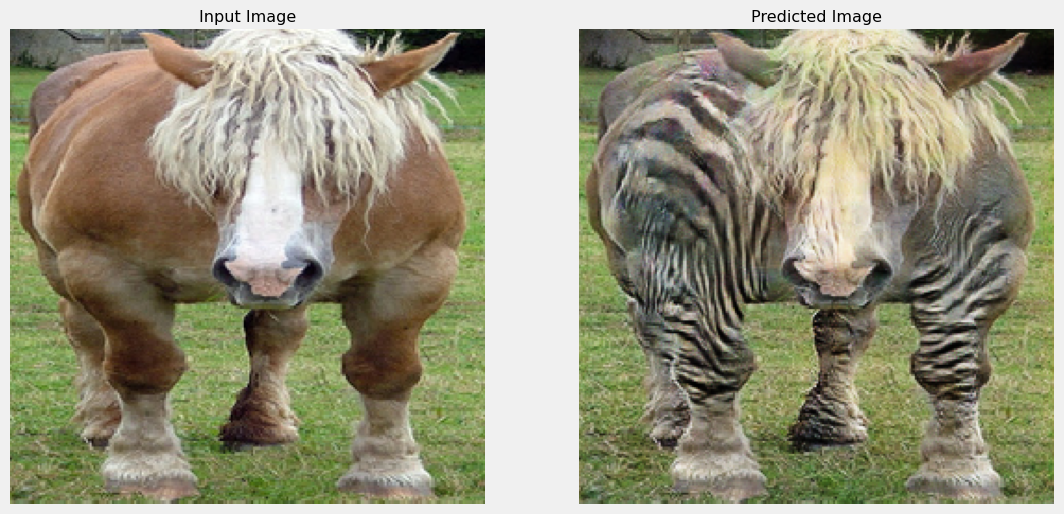

Time taken for epoch 150 is 142.40649604797363 sec

Saving checkpoint for epoch 150 at models\cycleGAN\ckpt-30


In [28]:
generate_images(generator_g, sample_horse)
for epoch in range(EPOCHS):
    start = time()

    for image_x, image_y in tqdm(tf.data.Dataset.zip((train_horses, train_zebras))):
        train_step(image_x, image_y)

    clear_output(wait=True)
    generate_images(generator_g, sample_horse)
    print(f'Time taken for epoch {epoch+1} is {time()-start} sec\n')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))